In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from pandas_datareader import data as pdr
from collections import deque
import random
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

In [15]:
df_full = pd.read_csv('BTC.csv')
df_full.pop('Currency')

0      BTC
1      BTC
2      BTC
3      BTC
4      BTC
      ... 
161    BTC
162    BTC
163    BTC
164    BTC
165    BTC
Name: Currency, Length: 166, dtype: object

In [16]:
df_full

,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD),Close
0,1/1/2021,29111.52157,28872.82977,29280.04533,27916.62506,2.911152
1,1/2/2021,29333.60512,28935.81098,29601.59490,28753.41231,2.933361
2,1/3/2021,32154.16736,29353.64061,33064.67353,29012.92789,3.215417
3,1/4/2021,33002.53643,32074.10661,34452.08034,31885.58162,3.300254
4,1/5/2021,31431.61228,32788.58345,33358.39935,28154.11030,3.143161
...,...,...,...,...,...,...
161,6/11/2021,36715.04710,37403.60397,38461.25074,35827.50618,3.671505
162,6/12/2021,37341.58943,36695.08131,37587.39855,35982.33038,3.734159
163,6/13/2021,35655.16445,37339.00024,37459.96028,34682.01043,3.565516
164,6/14/2021,38894.55627,35568.31876,39295.84866,34822.58005,3.889456


In [39]:
df= df_full.copy()
name = 'Q-Learning-Model'
class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        #-------------------------- 
        # Giai đoạn Định nghĩa
        #-------------------------- 
        #Kích cỡ của Size Q-Learning
        self.state_size = state_size
        #Kích cỡ Window
        self.window_size = window_size
        #Kích cỡ nữa Window
        self.half_window = window_size // 2
        #Giá trị mà ta quan tâm ở đây thường quan tâm đến Closing Price
        self.trend = trend
        #Bước nhảy
        self.skip = skip
        #Ví trong bài toán này chỉ có 3 hành động Buy/Sell/Hold --> action_size = 3
        self.action_size = 3
        self.batch_size = batch_size
        #Hàng đọi có chiều dài tối đa 1000 phần tử
        self.memory = deque(maxlen = 1000)
        self.inventory = []
        #Các hằng số của mô hình
        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        
        #-------------------------- 
        # Giai đoạn Deep Q-learning
        #-------------------------- 
        # 1. Pha chạy các thư viện tensorflow DQN
        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        # 2. Input
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        # 3. Output
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        # 4. Khởi tạo layer với hàm activtion là relu
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        # 5. Hàm chi phí trong DQN
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        # 6. Tối ưu hàm chi phí
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        # 7. Đưa các biến trong phiên làm việc của tensorflow DQN lên toàn cục
        self.sess.run(tf.global_variables_initializer())
        #-------------------------- 
    
    #Hàm chọn hành động giai đoạn đầu có thể là giá trị ngẫu nhiên tới một khoảng thời gian nào đó sẽ lấy hàm argmax để học
    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    def replay(self, batch_size):
        #Khởi tạo mini_batch là []
        mini_batch = []
        #Xem chiều dài của memory
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        #Truyền State và Action
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend)-1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    def train(self, iterations, checkpoint, initial_money):
        #self: chính là chính bản thân của class
        for i in range(iterations):
            #Tổng lợi nhuận ban đầu
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                #Hành động mua và bán
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                
                #Xem tiền đã bị giảm/tăng bao nhiêu phần sau mỗi lần giao dịch
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
              
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost, starting_money))

In [42]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 10
skip = 1
batch_size = 10
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
iteration_size = len(df_full)//batch_size
iteration_size = iteration_size*10
agent.train(iterations = iteration_size, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: -8.148757.3, cost: 0.000722, total money: 9966.338996
epoch: 20, total rewards: -8.311469.3, cost: 0.000657, total money: 9955.303451
epoch: 30, total rewards: -2.642930.3, cost: 0.000648, total money: 9957.080490
epoch: 40, total rewards: -4.767587.3, cost: 0.000640, total money: 9958.847333
epoch: 50, total rewards: -1.900886.3, cost: 0.000623, total money: 9965.139989
epoch: 60, total rewards: -4.767587.3, cost: 0.000631, total money: 9958.847333
epoch: 70, total rewards: -4.767587.3, cost: 0.000626, total money: 9958.847333
epoch: 80, total rewards: -2.837671.3, cost: 0.000611, total money: 9964.203204
epoch: 90, total rewards: -0.738331.3, cost: 0.000597, total money: 9970.111123
epoch: 100, total rewards: -0.786889.3, cost: 0.000593, total money: 9970.062564
epoch: 110, total rewards: -1.177725.3, cost: 0.000589, total money: 9969.671729
epoch: 120, total rewards: -3.810820.3, cost: 0.000610, total money: 9955.912599
epoch: 130, total rewards: -2.115561.

In [43]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 2: buy 1 unit at price 3.215417, total balance 9996.784583
day 5, sell 1 unit at price 3.443361, investment 7.089094 %, total balance 10000.227944,
day 6: buy 1 unit at price 3.627576, total balance 9996.600368
day 8: buy 1 unit at price 4.051945, total balance 9992.548423
day 9, sell 1 unit at price 4.025892, investment 10.980247 %, total balance 9996.574316,
day 10, sell 1 unit at price 3.870977, investment -4.466209 %, total balance 10000.445292,
day 14: buy 1 unit at price 3.843586, total balance 9996.601706
day 15: buy 1 unit at price 3.675158, total balance 9992.926548
day 16, sell 1 unit at price 3.601678, investment -6.293820 %, total balance 9996.528225,
day 17, sell 1 unit at price 3.637581, investment -1.022469 %, total balance 10000.165807,
day 18: buy 1 unit at price 3.634661, total balance 9996.531146
day 19, sell 1 unit at price 3.657752, investment 0.635300 %, total balance 10000.188898,
day 22: buy 1 unit at price 3.336837, total balance 9996.852061
day 23: buy 1 u

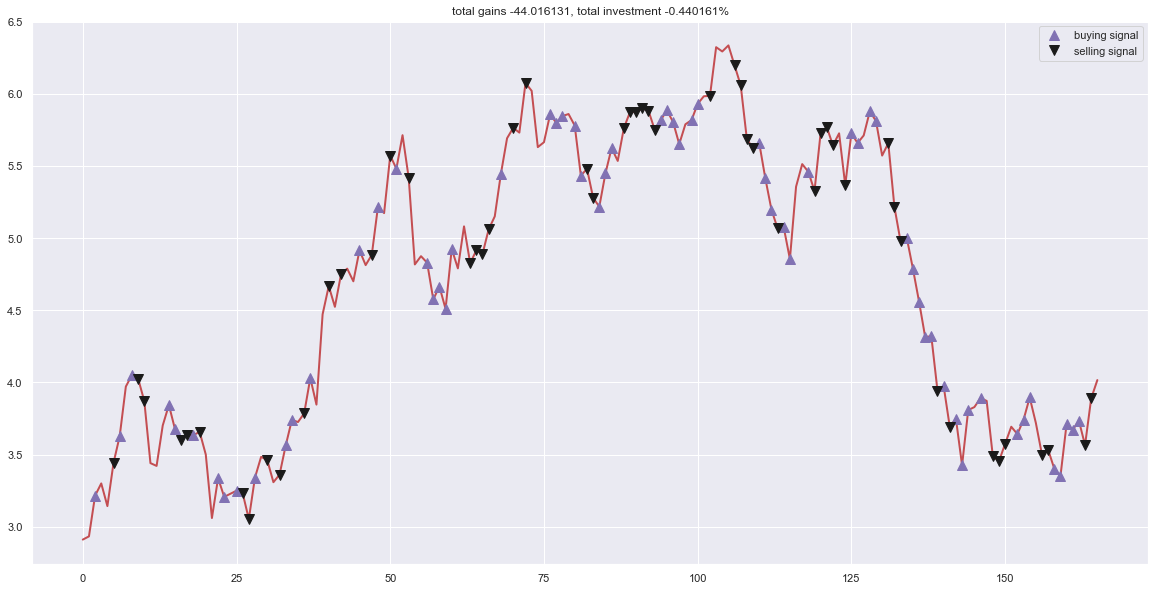

In [44]:
fig = plt.figure(figsize = (20,10))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig(name+'.png')
plt.show()